# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier

# Directories

In [2]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"one_vs_all/Long/XGBoost"

netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [6]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [7]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [8]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [9]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [10]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [4]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv")

In [5]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [6]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  50000
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  50000
Size of class 4 is  50000
Size of class 5 is  50000


# Features

In [7]:
def get_features(netconfig_path):
    
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

In [8]:
features_all = []

for one_particle in particles:
    
    netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
    + one_particle + "_Long_ANN.txt"

    features_all += get_features(netconfig_path)

In [9]:
features = numpy.unique(features_all)
features

array(['BremPIDe', 'CaloPrsE', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe',
       'HcalPIDmu', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon',
       'InAccPrs', 'MuonBkgLL', 'MuonIsLooseMuon', 'MuonIsMuon',
       'MuonMuLL', 'MuonNShared', 'PrsPIDe', 'RichAboveKaThres',
       'RichAboveMuThres', 'RichAbovePiThres', 'RichAbovePrThres',
       'RichDLLbt', 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp',
       'RichUsedR1Gas', 'RichUsedR2Gas', 'TrackChi2PerDof',
       'TrackFitMatchChi2', 'TrackFitTChi2', 'TrackFitTNDoF',
       'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackGhostProbability',
       'TrackNumDof', 'TrackP', 'TrackPt'], 
      dtype='|S21')

# Train XGBoost

In [10]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.01 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.0470898 ,  0.07890646,  0.41969519])

In [11]:
for i in numpy.unique(labels):
    print "Weight of class %d is " % i, weights[labels == i][0]

Weight of class 0 is  0.0470898
Weight of class 1 is  0.419695187166
Weight of class 2 is  0.0789064646939
Weight of class 3 is  0.0470898
Weight of class 4 is  0.0470898
Weight of class 5 is  0.0470898


In [12]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [ ]:
%%time
import os, sys
sys.path.append('../python')
from estimators import OneVsRestClassifier

xgboost = XGBoostClassifier(n_estimators=1000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=4, 
                        subsample=0.5, 
                        max_depth=8,
                        min_child_weight = 50,
                        features=features)

clf = OneVsRestClassifier(estimator = xgboost)

clf.fit(data.loc[train_inds], labels_train, sample_weight='balanced')

# Save the classifier

In [ ]:
params = clf.estimators_[0].get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [61]:
new_work_path = work_path + "/" + params_str + 'balanced_data_' + str(len(data))
new_work_path

'baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/one_vs_all/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;gamma=None;nthreads=4;balanced_data_235449'

In [ ]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
pickle.dump(clf, clf_pickle)
clf_pickle.close()

In [ ]:
# new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/\
# one_vs_all/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;\
# base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;\
# gamma=None;nthreads=4;balanced_data_235449"

In [ ]:
# Read classifier
# clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
# clf = pickle.load(clf_pickle2)
# clf_pickle2.close()

# Test the classifier

In [62]:
%%time
probas = clf.predict_proba(data.loc[test_inds])

CPU times: user 4min 4s, sys: 666 ms, total: 4min 5s
Wall time: 1min 14s


In [44]:
probas[:5, :]

array([[  3.19088250e-03,   1.47428061e-03,   6.66002103e-04,
          9.69213492e-04,   9.89790738e-01,   3.80557217e-02],
       [  2.69721225e-02,   1.07825571e-03,   3.01698828e-03,
          1.06138643e-02,   7.92707324e-01,   8.22973132e-01],
       [  9.90632772e-01,   2.22480074e-01,   9.63902194e-03,
          9.55061801e-03,   4.98293666e-03,   7.81737547e-03],
       [  3.16930622e-01,   3.16310190e-02,   1.88679509e-02,
          7.84511447e-01,   5.20819962e-01,   3.58862370e-01],
       [  1.99932054e-01,   1.63406273e-03,   2.70595239e-03,
          8.78235817e-01,   5.06793894e-02,   4.96805638e-01]])

### Logloss

In [ ]:
from sklearn.metrics import log_loss

def avg_log_loss(y_true, y_scores):
    
    classes = numpy.unique(y_true)
    avglogloss = 0
        
    for num, one_class in enumerate(classes):
            
        y_class = (y_true == one_class) * 1.
        
        one_logloss = log_loss(y_class, y_scores[:, num])
        
        avglogloss += one_logloss / len(classes) 
        
    return avglogloss

In [ ]:
from sklearn.metrics import log_loss

def get_logloss_curve(one_vs_rest_classifier, data, labels, curve_labels, n_points=10):
    
    classes = numpy.sort(numpy.unique(labels))
    
    plt.figure(figsize=(10,7))
    
    for one_class, one_name in zip(classes, curve_labels):
        
        estimator = one_vs_rest_classifier.estimators_[one_class]
        
        step = estimator.get_params()['n_estimators'] / n_points
        x = numpy.arange(step, estimator.get_params()['n_estimators'] + step, step)
        
        staged_probas = estimator.staged_predict_proba(data, step=step)
        
        log_loss_all = []
        for pred in staged_probas:
            one_labels = (labels == one_class) * 1.
            log_loss_all.append(log_loss(one_labels, pred))

        x = numpy.arange(step, estimator.get_params()['n_estimators'] + step, step)
        plt.plot(x, log_loss_all, label=str(one_name), linewidth=2)
        
        
    plt.title('Log loss curves', size=15)
    plt.ylabel('Log loss', size=15)
    plt.xlabel('Iteration', size=15)
    plt.legend(loc='best', prop={'size':15})
    plt.show()

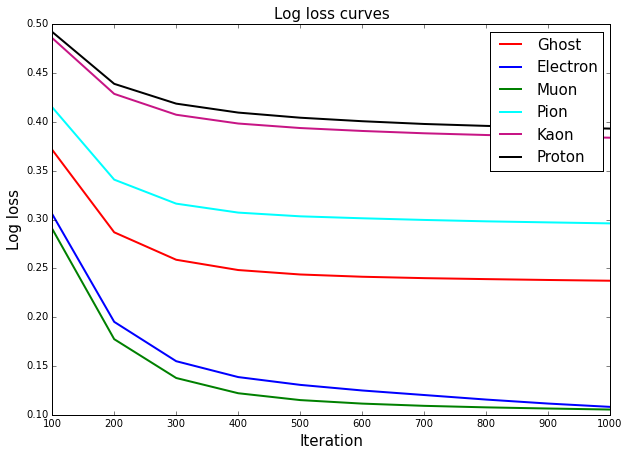

In [45]:
get_logloss_curve(clf, data.loc[test_inds], labels_test, particles, n_points=10)

In [46]:
from sklearn.metrics import log_loss

#log_loss(labels_test, probas)
print 'Avg. log loss is ', avg_log_loss(labels_test, probas)

Avg. log loss is  0.253947845098


### Roc curves

In [ ]:
import os, sys
sys.path.append('../python')
import utils

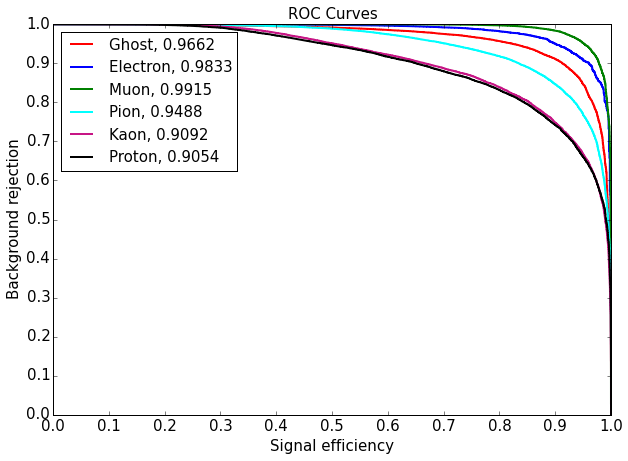

In [47]:
utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

# Evaluation

In [ ]:
import os, sys
sys.path.append('../python')
import utils

In [ ]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [ ]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

In [ ]:
%%time
proba_eval = clf.predict_proba(data_eval)

In [10]:
#numpy.savetxt(new_work_path + '/xgboost_proba_eval.csv', proba_eval)

In [12]:
#proba_eval = numpy.loadtxt(new_work_path + '/xgboost_proba_eval.csv')

In [48]:
proba_eval[:5, :]

array([[  4.12990246e-03,   3.21504287e-03,   1.68152787e-02,
          1.48399416e-02,   3.77330929e-01,   9.39977169e-01],
       [  5.28828800e-03,   6.47005043e-04,   5.36384468e-04,
          1.07362226e-03,   7.65976369e-01,   8.22742045e-01],
       [  6.77457526e-02,   1.58961629e-03,   1.69574339e-02,
          9.85416949e-01,   2.73604598e-02,   3.06115672e-02],
       [  4.74904627e-01,   1.14349924e-01,   6.85108965e-03,
          7.92007029e-01,   1.65391013e-01,   2.45405540e-01],
       [  3.89215425e-02,   1.34419894e-03,   9.90529661e-04,
          9.94035244e-01,   1.83970435e-03,   1.69304712e-03]])

### Get all figures from baseline

In [18]:
from get_figures import all_figures

In [19]:
for num in range(0, len(particles)):
        
    one_particle = particles[num]
    one_lab = labs[num]

    one_labels = (labels_eval == one_lab)*1
    one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
    params = {}
    params['PARTICLE'] = one_particle
    params['TRACK'] = 'Long'
    
    all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")

### Logloss

In [49]:
from sklearn.metrics import log_loss

#logloss = log_loss(labels_eval, proba_eval)
logloss = avg_log_loss(labels_eval, proba_eval)
print 'Avg. log loss is ', logloss
numpy.savetxt(new_work_path + '/logloss_eval.csv', [logloss])

Avg. log loss is  0.249149097881


### Roc curves, roc auc matrix and roc auc ratio matrix

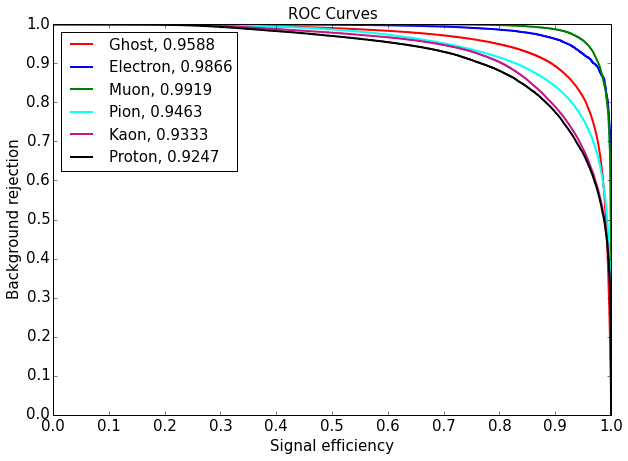

In [50]:
utils.get_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

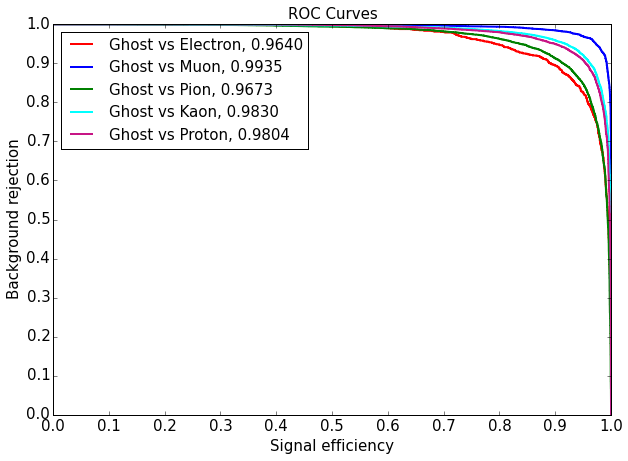

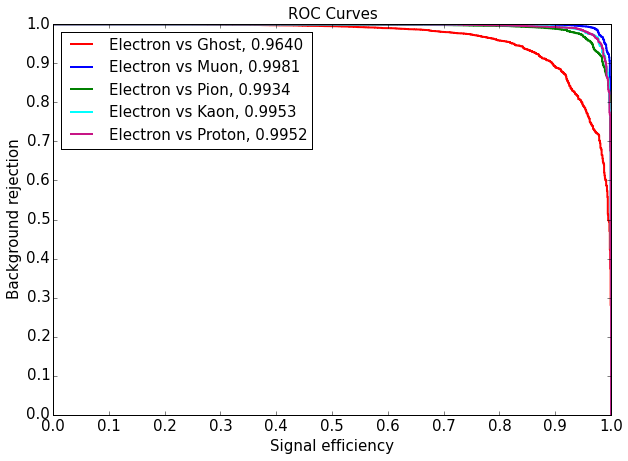

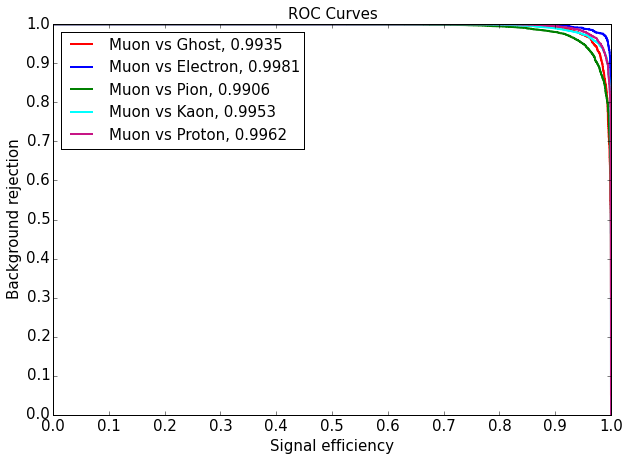

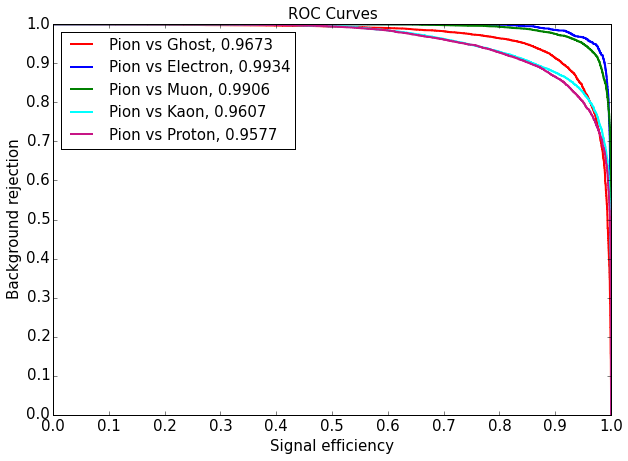

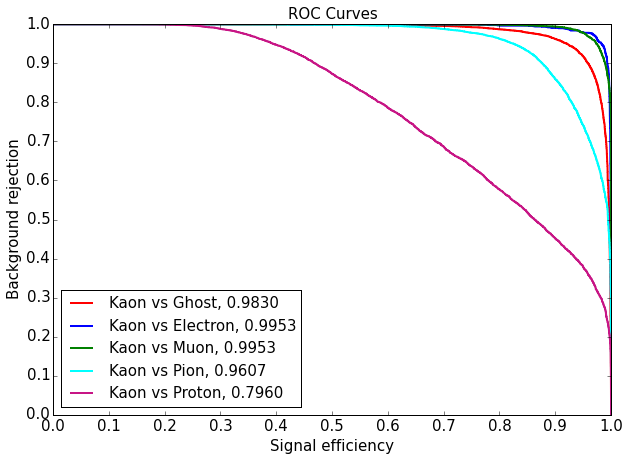

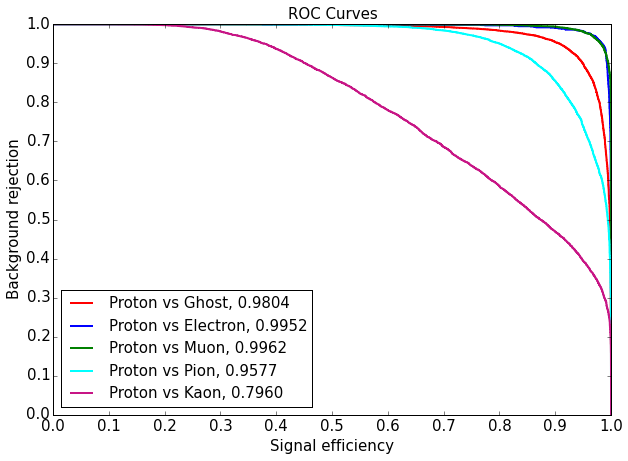

In [60]:
utils.get_one_vs_one_roc_curves(labels_test, probas, particles, save_path=new_work_path, show=True)

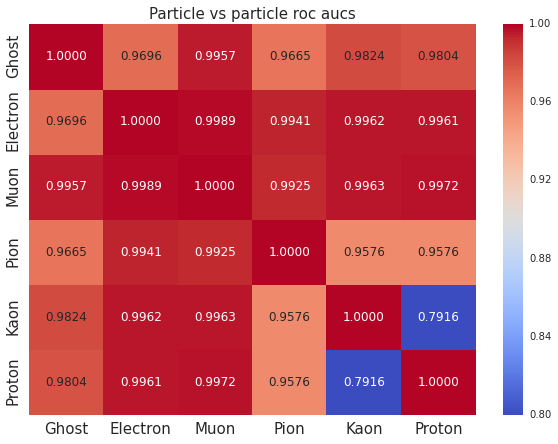

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.969573,0.995744,0.966513,0.982366,0.980409
Electron,0.969573,1.000000,0.998876,0.994126,0.996169,0.996129
Muon,0.995744,0.998876,1.000000,0.992470,0.996299,0.997225
Pion,0.966513,0.994126,0.992470,1.000000,0.957618,0.957636
Kaon,0.982366,0.996169,0.996299,0.957618,1.000000,0.791632
Proton,0.980409,0.996129,0.997225,0.957636,0.791632,1.000000


In [51]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)
roc_auc_matrix

In [52]:
roc_auc_matrix_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv", index_col=0)

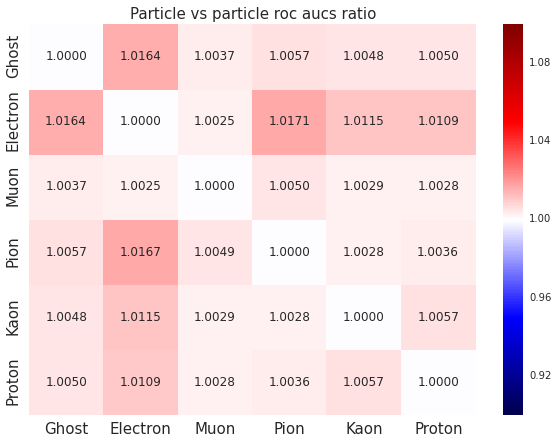

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,1.016375,1.003658,1.005661,1.004757,1.005019
Electron,1.016375,1.000000,1.002497,1.017060,1.011457,1.010939
Muon,1.003658,1.002494,1.000000,1.004959,1.002940,1.002768
Pion,1.005661,1.016726,1.004933,1.000000,1.002808,1.003644
Kaon,1.004757,1.011490,1.002940,1.002808,1.000000,1.005668
Proton,1.005019,1.010934,1.002768,1.003643,1.005668,1.000000


In [53]:
utils.get_roc_auc_ratio_matrix(roc_auc_matrix, roc_auc_matrix_baseline, save_path=new_work_path, show=True)

### Flatness

In [54]:
%%time
flatness = utils.get_flatness_table(data_eval, labels_eval, proba_eval, particles, save_path=new_work_path)

CPU times: user 18min 3s, sys: 33 ms, total: 18min 3s
Wall time: 18min 3s


In [55]:
flatness

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Ghost,0.009313,0.030882,0.000861,0.000865
Electron,0.007605,0.027245,0.000979,0.000960
Muon,0.031079,0.045270,0.000881,0.000906
Pion,0.017933,0.014587,0.000855,0.000851
Kaon,0.049156,0.035430,0.000874,0.000863
Proton,0.037730,0.045864,0.000885,0.000887


In [56]:
flatness_baseline = pandas.read_csv("../python/flatness_baseline.csv", index_col=0)
flatness_baseline

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Electron,0.006546,0.016579,0.001014,0.001004
Proton,0.034632,0.044571,0.000886,0.000888
Pion,0.016512,0.013729,0.000853,0.000851
Muon,0.020388,0.044991,0.000905,0.000906
Kaon,0.043074,0.036657,0.000872,0.000880
Ghost,0.006591,0.014187,0.000871,0.000870


In [57]:
utils.get_flatness_ratio(flatness, flatness_baseline, save_path=new_work_path)

,TrackP,TrackPt
Ghost,1.413033,2.176722
Electron,1.161822,1.643352
Muon,1.524399,1.006189
Pion,1.086035,1.062552
Kaon,1.141198,0.966512
Proton,1.089466,1.028993


### Efficiency curves

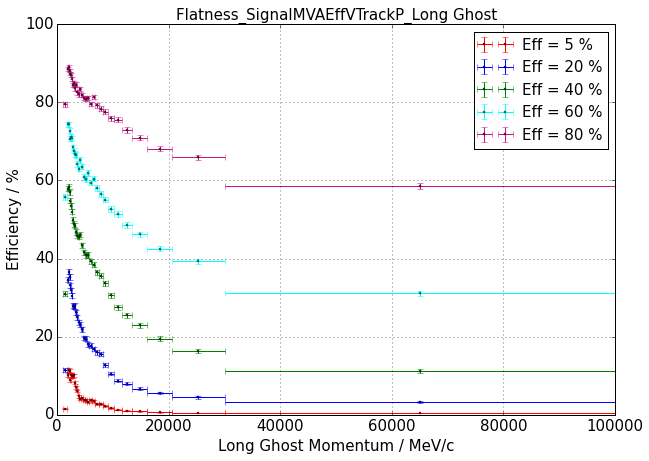

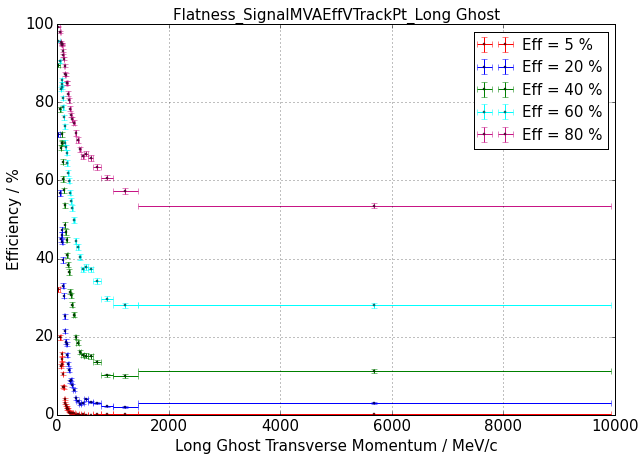

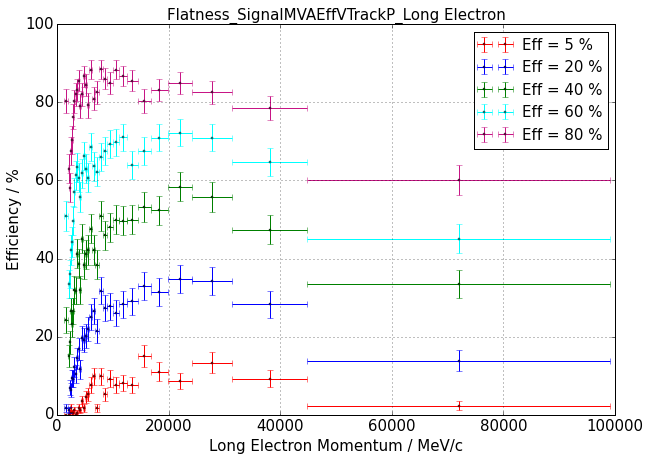

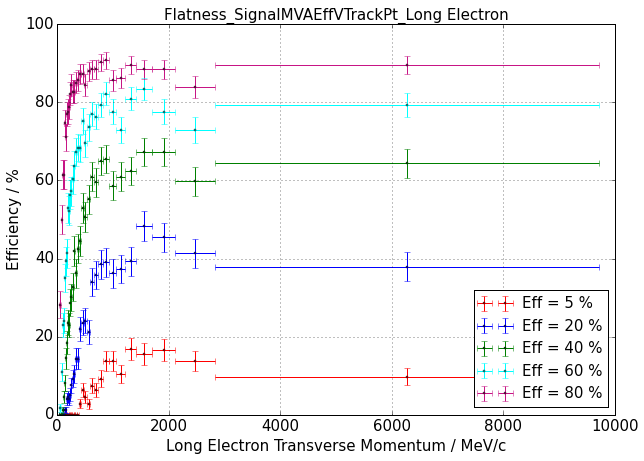

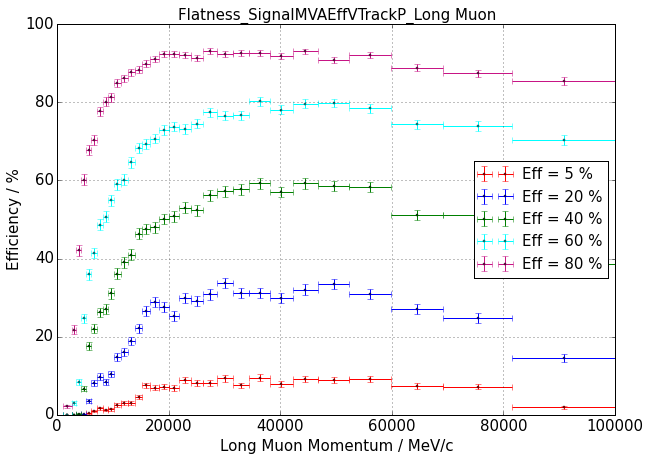

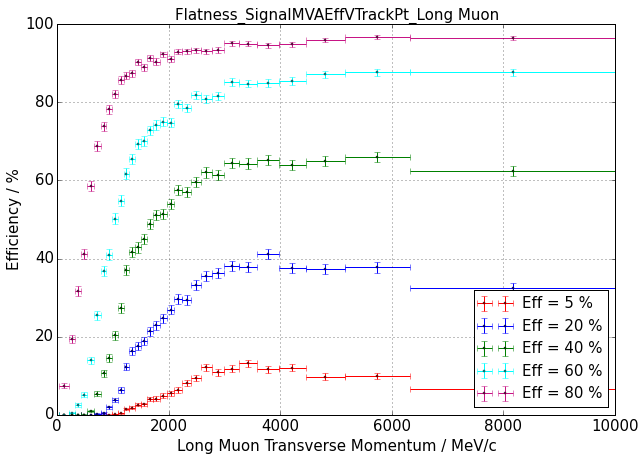

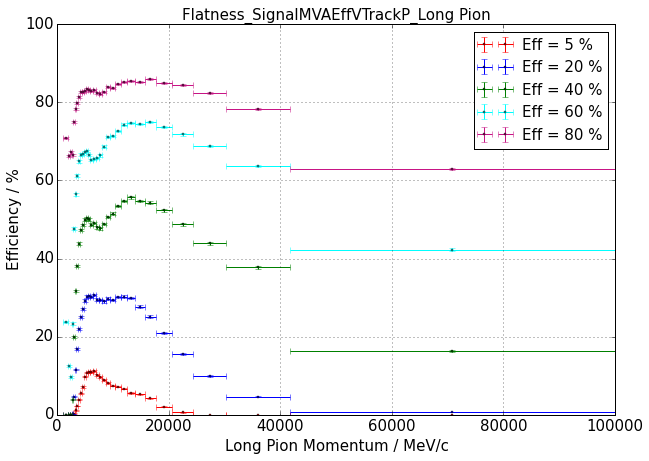

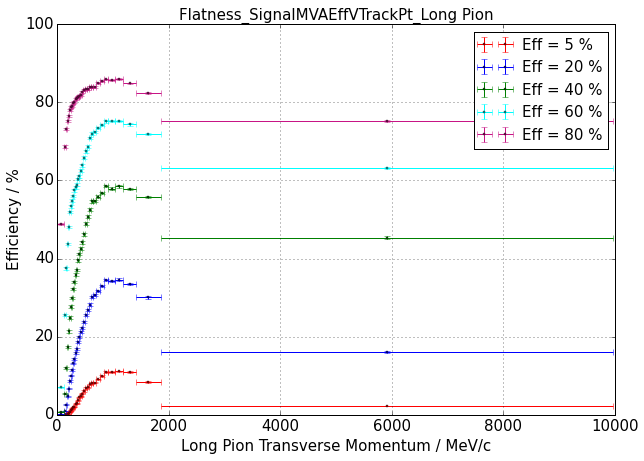

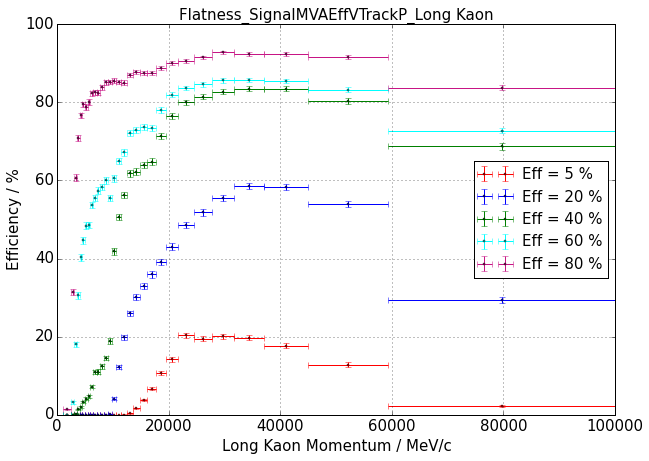

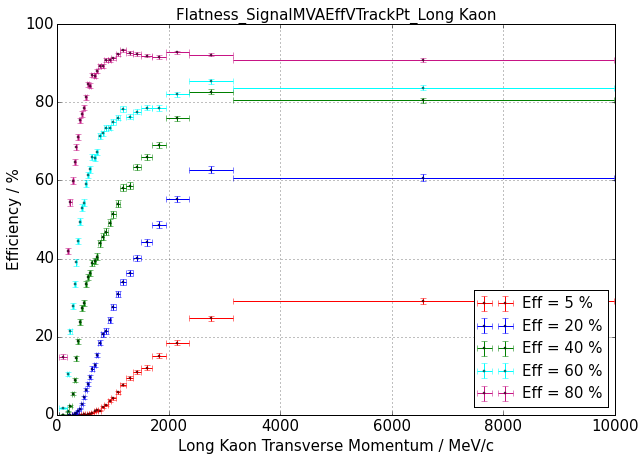

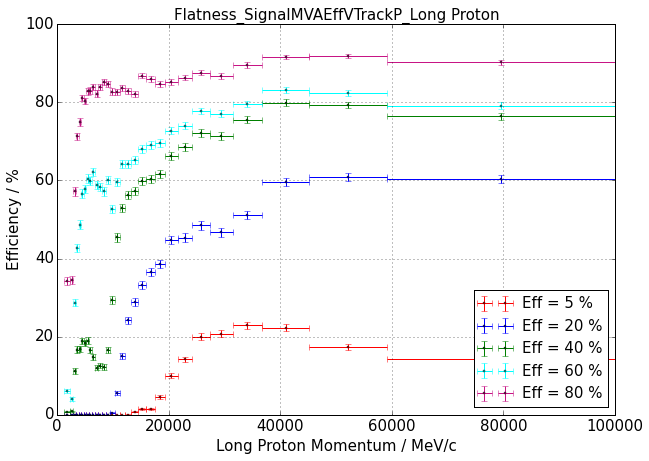

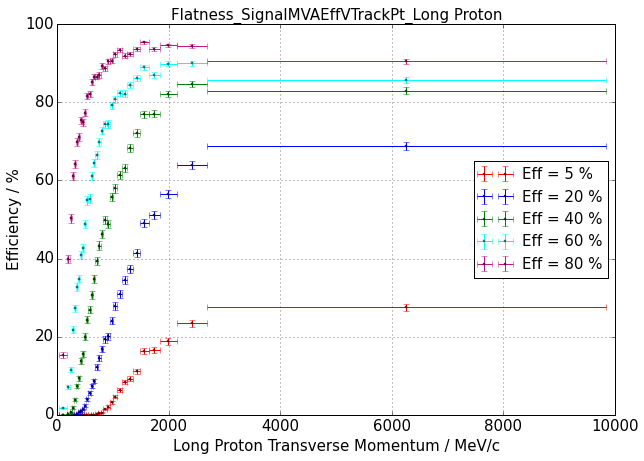

In [58]:
utils.get_all_flatness_figures(data_eval, proba_eval, labels_eval, 'Long', particles, save_path=new_work_path, show=True)